# Automated Click Classification
## This example uses larger-scale data with quite a bit more complexity.

Sharon's demo established some of the capabilities of Pandas.

Here, we'll build on that - but the code will get a bit more advanced, so don't focus too much on that while we're running through it.

Instead, pay more attention to the general techniques - many of them are applicable outside of Pandas and python.

### Note: The underlying data is not available on Colab, so treat this as read-only.

In [4]:
import datetime
import os
import random
import sys

from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd

# commented out; won't work on colab
# from clicks_nbdev.offline_augmentation import asnLookup
# asndb = asnLookup()


In [5]:
def value_counts_multi(df, group_column, return_columns):
    # Returns a new df, grouped by specified columns, returning return_columns, sorted by count descending.
    # return_columns should be a list.
    
    # Actually grouping doesn't work quite right, but it's good enough for 
    
    newcolname = str(group_column) + "_count"
    
    df1 = pd.DataFrame(df.groupby(return_columns)[group_column].count())
    df1 = df1.rename(columns={group_column:newcolname}).reset_index().sort_values(newcolname, ascending=False)
    return df1.reset_index().drop('index', axis='columns')
    
    
def df_counts(df, column, head=None):
    # returns a df of value_counts of the column.
    col = str(column)
    if head:
        top_values = df[column].value_counts().head(head)
    else:
        top_values = df[column].value_counts()
        
    colname = col + "_count"
    top_values = top_values.rename_axis(column).reset_index(name=colname)
    top_values[colname] = top_values[colname].astype('int32')
    return top_values

## Let's talk about cleaning data.

In [6]:
with open('rawlog.txt', 'r') as f:
    log = f.readlines()

log = [i.rstrip("\n") for i in log]

In [7]:
for i in log:
    print(i)

[10/Nov/2019:06:06:48] 1.2.3.4 + - www.example.com "GET /c.html?ufl=a&rtr=on&s=abcdef,bcde,cdef,defg,efgh,fghi,ghij&MLM_MID=123456 HTTP/1.1" 302 26 "-" "Mozilla/5.0 (iPad; CPU OS 13_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.1 Mobile/15E148 Safari/604.1"
[10/Nov/2019:03:51:00] 1.2.3.4 - - 1.2.3.4:107 "GET /crossdomain.xml HTTP/1.1" 200 1051 "-" "ELB-HealthChecker/2.0"
[10/Nov/2019:04:04:21] 1.2.3.4 - - 1.2.3.4:107 "GET /crossdomain.xml HTTP/1.1" 200 1051 "-" "ELB-HealthChecker/2.0"
[10/Nov/2019:06:58:11] 1.2.3.4 + - www.example.com "GET /c.html?ufl=7&rtr=on&s=abcdef,bcde,cdef,defg,efgh,fghi,ghij&MLM_MID=123456 HTTP/1.1" 302 26 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.2 Safari/605.1.15"
[10/Nov/2019:03:55:42] 1.2.3.4 - - 1.2.3.4:107 "GET /crossdomain.xml HTTP/1.1" 200 1051 "-" "ELB-HealthChecker/2.0"
[10/Nov/2019:04:25:14] 1.2.3.4 + - www.example.com "GET /c.html?ufl=c&rtr=on&s=abcdef,bcde,cd

## Cleaning steps:
- Run a log parsing module. Handle parsing errors without crashing the parsing pipeline; log error rates.
- Filter to lines containing click tracking links (e.g., /c.html)



- Do a lot of sanity checking of click tracking links. 
    - Expected click string should look like:

           abcdef,bcde,cdef,defg,efgh,fghi,ghij
      
      
      7 sections, alphanumeric, between 32 and 40 characters.

    - Is it within expected length ranges?
    - These are comma separated. Are there enough commas in the string?
    - These only contain alphanumeric characters. Are there any invalid characters?
    - If a line doesn't pass, fill data with 0s for values.





Real-world examples of strings that came back:

    '3Dabcd=',
    'abcdef,bcde,cdef,defg,efgh,fghi,ghij,9tkII,defg,efgh,fghi,ghij',
    "abcdef,bcde,cdef,defg,efgh,fghi,ghij') UNION ALL SELECT NULL,NULL-- ",
    "abcdef,bcde,cdef,defg,efgh,fghi,ghij%' UNION ALL SELECT NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL-- ",
    'abcdef,bcde,cdefdefgefghfghighij',
    'abcdef,3kxxxxx2xxxxx,xxxxxefgh,fghi,xxxxx,xxxxx',


What does a 0.1% error rate mean when you're parsing 100 million rows?

## Data Augmentation / Feature Engineering

What can we do to our data that might give us more tools to analyze it, and/or, to classify it later on?

A few things to start with:
- Convert IPs to /24s
- Look up ASNs, enclosing CIDRs, and AS organization names for the IPs
- Extract details from the user-agent strings - OS, OS version, browser type, browser version



In [332]:
# Let's load some known good data.
gdf = pd.read_pickle('good_20200216.p')

In [333]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88305 entries, 1 to 1682953
Data columns (total 26 columns):
request_time                                          88305 non-null datetime64[ns, UTC]
remote_ip                                             88305 non-null object
conn_status                                           88305 non-null object
request_method                                        88305 non-null object
request_url_path                                      88305 non-null object
request_url_query_simple_dict                         88305 non-null object
status                                                88305 non-null object
response_bytes_clf                                    88305 non-null object
request_header_referer                                88305 non-null object
request_header_user_agent                             88305 non-null object
request_header_user_agent__browser__family            88305 non-null object
request_header_user_agent__browser__vers

# Data points
### - IP, User-Agent, Click Delay

What do we expect standard user behavior to look like?

- Traffic should come from a lot of different IPs.
    - Exceptions:
        - Mail sent prmarily to corporate domains may originate from NAT IPs instead of end user IPs.
        
     
- Traffic should have a lot of different User-Agent strings.
    - Exceptions:
        - Mailbox providers using image proxies (Gmail, Yahoo)
        - Corporate networks with heavily standardized IT
 
        
- Traffic should have a lot of variation in how long a user takes to click on a message once it's received.
    - Exceptions:
        - Automated systems that load images or links as part of evaluating whether they are spam or malicious
        

In [334]:
# Let's look at data for good IPs first.
value_counts_multi(gdf, 'netblock', ['netblock','as_org']).head(12)

,netblock,as_org,netblock_count
0,73.0.0.0/8,"COMCAST-7922, US",3658
1,74.125.0.0/16,"GOOGLE, US",2367
2,172.58.136.0/21,"T-MOBILE-AS21928, US",1435
3,172.58.104.0/21,"T-MOBILE-AS21928, US",1270
4,34.208.0.0/12,"AMAZON-02, US",1251
5,66.102.0.0/20,"GOOGLE, US",1066
6,66.249.88.0/24,"GOOGLE, US",1052
7,172.58.152.0/21,"T-MOBILE-AS21928, US",916
8,3.80.0.0/12,"AMAZON-AES, US",865
9,172.58.168.0/21,"T-MOBILE-AS21928, US",861


In [335]:
# And what kind of user-agents we have for this:
gdf.request_header_user_agent.value_counts().head(10)

Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Mobile/15E148 Safari/604.1                6899
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36                                       2195
Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/79.0.3945.73 Mobile/15E148 Safari/604.1            2107
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.93 Safari/537.36                                                    1221
Mozilla/5.0 (Linux; Android 9; LM-Q720) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.93 Mobile Safari/537.36                                   900
Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1                 748
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKi

In [264]:
# Before we can look at click delay, we'll need to calculate that.
# Actual send time is not in these logs, but we can get something close if we look for
# This approach isn't perfect, but it's good enough for some initial exploration.

def calc_min_click_time(df):

    # Let's look at the timing of these clicks.
    # As a baseline, we look at the earlest click for each message, so let's calcuate that.
    min_timestamp_per_message = df.groupby('farm_mid')['request_time'].min()
    mints = pd.DataFrame(min_timestamp_per_message)
    mints = mints.rename({"request_time":"min_request_time"}, axis='columns')
    return mints

min_clicks = calc_min_click_time(gdf)
min_clicks.head().copy().reset_index().drop('farm_mid', axis='columns')

,min_request_time
0,2020-01-01 09:28:01+00:00
1,2020-01-01 20:42:19+00:00
2,2020-01-03 19:37:58+00:00
3,2020-01-05 06:29:48+00:00
4,2020-01-10 22:27:22+00:00


In [265]:
# Then join back to the original data.
if 'min_request_time' not in gdf.columns:
    gdf = gdf.join(min_clicks, 'farm_mid')
    
# Now we can calculate the 'delay' for each click vs. the earlieset click time.
gdf['click_delay'] = gdf.request_time - gdf.min_request_time

gdf['clickdelay_minutes'] = gdf.click_delay / pd.Timedelta(minutes=1)
gdf['clickdelay_hours'] = gdf.click_delay / pd.Timedelta(hours=1)

# Look at some values.
gdf[['min_request_time', 'request_time', 'click_delay']].sample(10)

,min_request_time,request_time,click_delay
index,,,
938615,2020-01-15 18:19:13+00:00,2020-01-16 00:15:42+00:00,05:56:29
211371,2020-01-13 03:12:18+00:00,2020-01-13 03:58:53+00:00,00:46:35
871135,2020-01-08 21:09:59+00:00,2020-01-08 21:21:42+00:00,00:11:43
778663,2020-01-15 11:15:44+00:00,2020-01-15 11:16:13+00:00,00:00:29
1616869,2020-01-18 21:08:55+00:00,2020-01-18 21:20:01+00:00,00:11:06
745248,2020-01-15 04:39:11+00:00,2020-01-15 05:46:20+00:00,01:07:09
71761,2019-12-29 14:01:19+00:00,2019-12-29 16:09:48+00:00,02:08:29
983349,2020-01-08 22:17:28+00:00,2020-01-09 06:15:09+00:00,07:57:41
628028,2020-01-14 18:21:40+00:00,2020-01-14 20:07:48+00:00,01:46:08


In [266]:
## Let's set up some functions that help us look at delivery timing.

In [295]:
def ua_analyzer(df, column, value):
    d2 = df[df[column] == value]
    ua_cols = [i for i in df.columns if 'request_header_user_agent' in i]
    
    print("count:", d2.shape[0])
    
    for i in ua_cols:
        print(i + ":")
        print(d2[i].value_counts().head())
        print()
    if column != 'ip_slash24':
        print("IP/24s:\n{}\n".format(d2['ip_slash24'].value_counts().head(8)))
    print("AS Orgs:\n{}\n".format(d2['as_org'].value_counts().head(8)))
    if column != 'netblock':
        print("Netblocks:\n{}\n".format(d2['netblock'].value_counts().head(8)))
    show_delay_pctiles(d2, 'clickdelay_minutes')
    hist(d2)


def show_delay_pctiles(df, column='clickdelay_minutes', quantiles=None):
    
    print("Percentiles for {}:".format(column))

    if not quantiles:
        # use default
        quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

    for i in quantiles:
        delay_mins = df[column].quantile(i)

        delay = datetime.timedelta(minutes=delay_mins)
        delay = delay - datetime.timedelta(microseconds=delay.microseconds)
        print(100*i, delay, sep="\t")
    

def hist(df, graph_col='clickdelay_minutes', upper_bound=None):
    
    if not upper_bound:
        # calc based on data
        pctile = 0.8
        pctile_value = df[graph_col].quantile(pctile)
        
        # bounds check
        if pctile_value < 0.05:
            pctile_value = 0.1

        print("{}th percentile: {}".format(100*pctile, round(pctile_value,1)))
              
        #upper_bound = cdftop1['clickdelay_minutes'].mean() + 1 + 2 * cdftop1['clickdelay_minutes'].std()
        upper_bound = pctile_value * 1.1

    # Calculate bins, evenly spaced
    bin_count = 100
    bins = [(i * upper_bound / bin_count) for i in range(bin_count+1)]


    df.hist(column=graph_col, bins=bins, figsize=(18,10))

In [296]:
show_delay_pctiles(gdf)

Percentiles for clickdelay_minutes:
5.0	0:06:53
25.0	0:58:40
50.0	3:16:52
75.0	11:33:19
95.0	2 days, 0:51:48


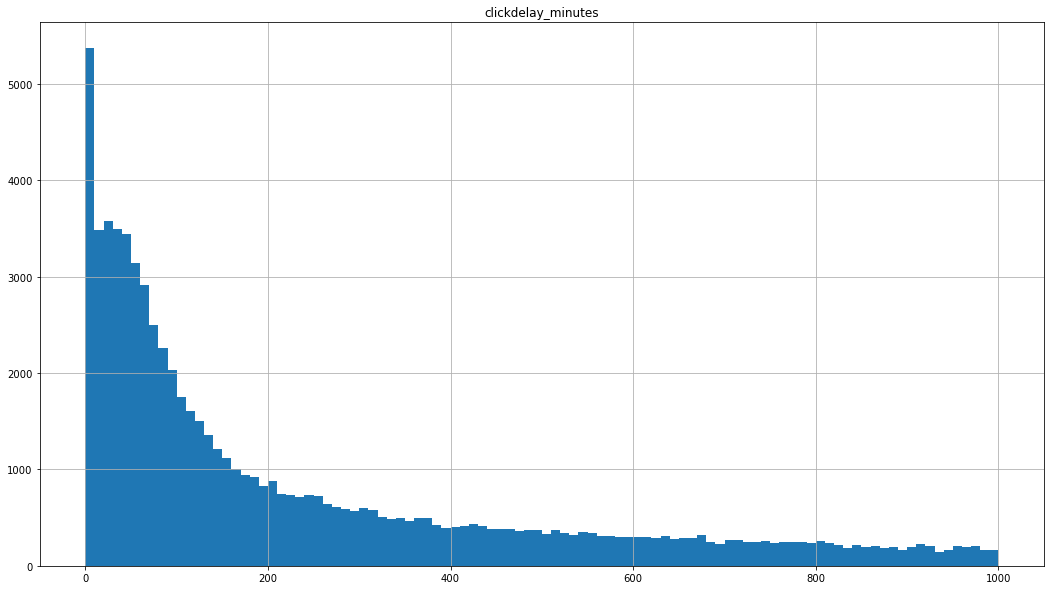

In [297]:
hist(gdf, upper_bound=1000)

## Let's dig into some of those user-agents.

In [298]:
c = df_counts(gdf, 'request_header_user_agent', head=20)
gdf.request_header_user_agent.value_counts().head(15)

Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Mobile/15E148 Safari/604.1                6899
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36                                       2195
Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/79.0.3945.73 Mobile/15E148 Safari/604.1            2107
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.93 Safari/537.36                                                    1221
Mozilla/5.0 (Linux; Android 9; LM-Q720) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.93 Mobile Safari/537.36                                   900
Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1                 748
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKi

Mozilla/5.0 (Linux; Android 8.0.0; moto e5 play Build/OCPS27.91-23-3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.91 Mobile Safari/537.36
count: 700
request_header_user_agent:
Mozilla/5.0 (Linux; Android 8.0.0; moto e5 play Build/OCPS27.91-23-3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.91 Mobile Safari/537.36    700
Name: request_header_user_agent, dtype: int64

request_header_user_agent__browser__family:
Chrome Mobile    700
Name: request_header_user_agent__browser__family, dtype: int64

request_header_user_agent__browser__version_string:
68.0.3440    700
Name: request_header_user_agent__browser__version_string, dtype: int64

request_header_user_agent__os__family:
Android    700
Name: request_header_user_agent__os__family, dtype: int64

request_header_user_agent__os__version_string:
8.0.0    700
Name: request_header_user_agent__os__version_string, dtype: int64

request_header_user_agent__is_mobile:
True    700
Name: request_header_user_agent__is_mobile, dtyp

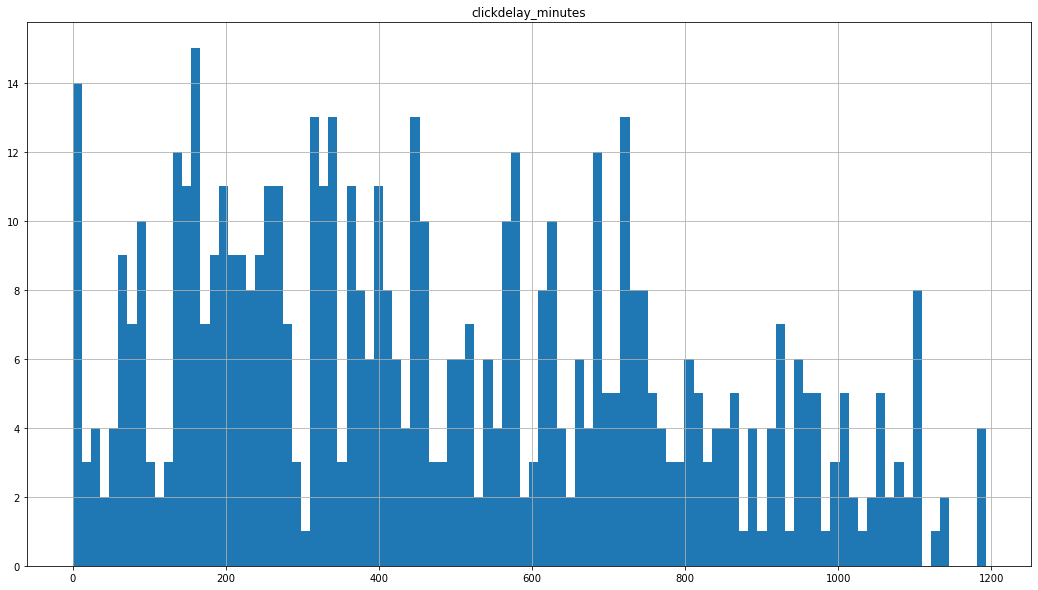

In [299]:
# suspicious = 3 (chrome 45), 7-8 (chrome 68, 38), 
ua = c.request_header_user_agent.tolist()[7]
print(ua)

ua_analyzer(gdf, 'request_header_user_agent', ua)

In [300]:
g_suspicious_uas = []
for i in [3, 7, 8]:
    g_suspicious_uas.append(c.request_header_user_agent.tolist()[i])

for i in g_suspicious_uas:
    print(i)

Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.93 Safari/537.36
Mozilla/5.0 (Linux; Android 8.0.0; moto e5 play Build/OCPS27.91-23-3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.91 Mobile Safari/537.36
Mozilla/5.0 (Linux; Android 5.1.1; A570BL Build/LMY47V) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/38.0.2125.102 Mobile Safari/537.36


In [301]:
d = df_counts(gdf, 'netblock', head=20)
value_counts_multi(gdf, 'netblock', ['netblock','as_org']).head(10)

,netblock,as_org,netblock_count
0,73.0.0.0/8,"COMCAST-7922, US",3658
1,74.125.0.0/16,"GOOGLE, US",2367
2,172.58.136.0/21,"T-MOBILE-AS21928, US",1435
3,172.58.104.0/21,"T-MOBILE-AS21928, US",1270
4,34.208.0.0/12,"AMAZON-02, US",1251
5,66.102.0.0/20,"GOOGLE, US",1066
6,66.249.88.0/24,"GOOGLE, US",1052
7,172.58.152.0/21,"T-MOBILE-AS21928, US",916
8,3.80.0.0/12,"AMAZON-AES, US",865
9,172.58.168.0/21,"T-MOBILE-AS21928, US",861


In [302]:
def nblock_to_ip(nb):
    return nb.split("/")[0]

('34.208.0.0/12', 'AMAZON-02, US')
count: 1251
request_header_user_agent:
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.93 Safari/537.36                                                    172
Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Mobile/15E148 Safari/604.1                 98
Mozilla/5.0 (Linux; Android 8.0.0; moto e5 play Build/OCPS27.91-23-3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.91 Mobile Safari/537.36     87
Mozilla/5.0 (Linux; Android 8.1.0; LM-X210APM) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Mobile Safari/537.36                           76
Mozilla/5.0 (Linux; Android 5.1.1; A570BL Build/LMY47V) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/38.0.2125.102 Mobile Safari/537.36      61
Name: request_header_user_agent, dtype: int64

request_header_user_agent__browser__family:
Chrome Mobile    845
Chrome           195
Mobile S

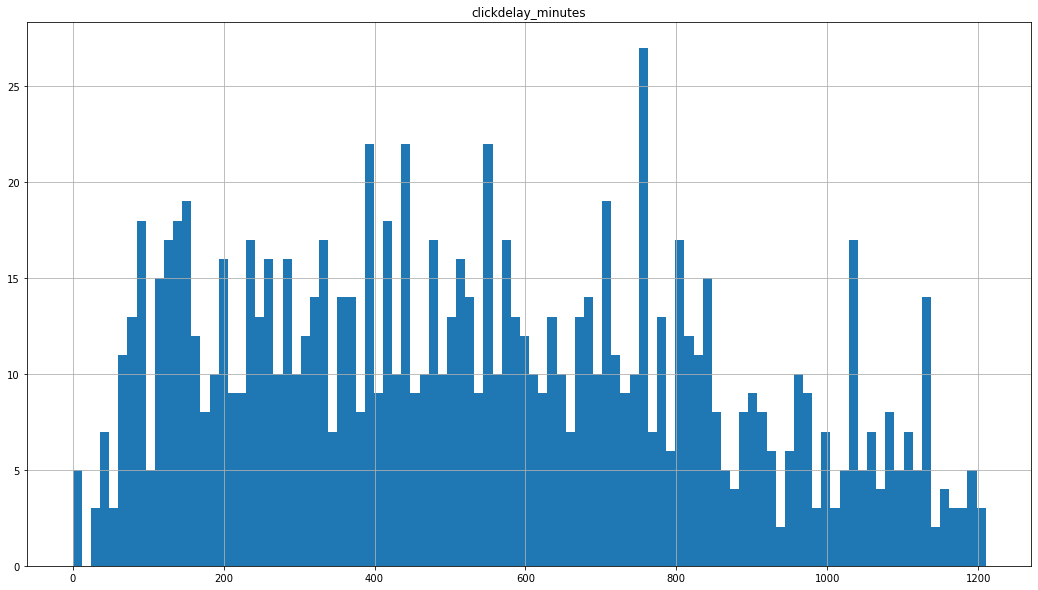

In [303]:
# suspicous: 4,
nblock = d.netblock.tolist()[4]
print(asndb.get_asn_details(nblock_to_ip(nblock))[1:])
ua_analyzer(gdf, 'netblock', nblock)

In [305]:
g_suspicious_nbs = []
for i in [4]:
    g_suspicious_nbs.append(d.netblock.tolist()[i])
    
print(g_suspicious_nbs)

['34.208.0.0/12']


In [306]:
## Let's set columns for any row with a UA or IP in these lists so we can determine how many rows we're talking about.

gdf['suspicious_ua'] = gdf['request_header_user_agent'].isin(g_suspicious_uas)
gdf['suspicious_ua'].value_counts(normalize=True) * 100

False    97.114546
True      2.885454
Name: suspicious_ua, dtype: float64

In [307]:
gdf['suspicious_nb'] = gdf['netblock'].isin(g_suspicious_nbs)
gdf['suspicious_nb'].value_counts(normalize=True) * 100

False    98.583319
True      1.416681
Name: suspicious_nb, dtype: float64

In [308]:
gdf['both_suspicious'] = gdf[['suspicious_ua', 'suspicious_nb']].all(1)
gdf['both_suspicious'].value_counts(normalize=True) * 100

False    99.63762
True      0.36238
Name: both_suspicious, dtype: float64

In [309]:
gdf['either_suspicious'] = gdf[['suspicious_ua', 'suspicious_nb']].any(1)
gdf['either_suspicious'].value_counts(normalize=True) * 100

False    96.060246
True      3.939754
Name: either_suspicious, dtype: float64

## Now, let's look at some data that has a bit more more automated activity in it.

In [310]:
%time bdf = pd.read_pickle('not_so_good_20200216.p')
bdf.shape

CPU times: user 1.65 s, sys: 504 ms, total: 2.15 s
Wall time: 2.58 s


(397643, 26)

In [311]:
# Add the click delay columns to this new dataset.

min_clicks = calc_min_click_time(bdf)

# Then join back to the original data.
if 'min_request_time' not in bdf.columns:
    bdf = bdf.join(min_clicks, 'farm_mid')
    
# Now we can calculate the 'delay' for each click vs. the earlieset click time.
bdf['click_delay'] = bdf.request_time - bdf.min_request_time

# And set a numeric time column for doing operations that require a numeric type.
bdf['clickdelay_minutes'] = bdf.click_delay / pd.Timedelta(minutes=1)
bdf['clickdelay_hours'] = bdf.click_delay / pd.Timedelta(hours=1)

# Look at some values.
bdf[['min_request_time', 'request_time', 'click_delay', 'clickdelay_minutes']].sample(5)

,min_request_time,request_time,click_delay,clickdelay_minutes
index,,,,
308774,2019-12-29 03:16:48+00:00,2020-01-11 11:18:38+00:00,13 days 08:01:50,19201.833333
227425,2020-01-17 13:07:59+00:00,2020-01-18 03:52:25+00:00,0 days 14:44:26,884.433333
306367,2019-12-30 00:25:47+00:00,2020-01-04 14:59:00+00:00,5 days 14:33:13,8073.216667
179037,2020-01-09 23:20:48+00:00,2020-01-09 23:21:14+00:00,0 days 00:00:26,0.433333
165523,2020-01-01 15:14:04+00:00,2020-01-01 16:50:45+00:00,0 days 01:36:41,96.683333


In [312]:
value_counts_multi(bdf, 'remote_ip', ['netblock','as_org']).head(10)

,netblock,as_org,remote_ip_count
0,209.222.82.0/24,"AMAZON-02, US",45828
1,65.154.226.0/24,"PAN0001, US",12856
2,34.208.0.0/12,"AMAZON-02, US",8403
3,40.64.0.0/10,"MICROSOFT-CORP-MSN-AS-BLOCK, US",8307
4,45.41.128.0/18,"WEB2OBJECTS, US",6582
5,73.0.0.0/8,"COMCAST-7922, US",6529
6,74.125.0.0/16,"GOOGLE, US",5121
7,66.102.8.0/23,"GOOGLE, US",4847
8,64.233.172.0/23,"GOOGLE, US",3946
9,107.0.0.0/14,"COMCAST-7922, US",3862


In [314]:
bdf.request_header_user_agent.value_counts().head(10)

Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0)                                                                                                                                   48167
Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729)                                                         47208
Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Mobile/15E148 Safari/604.1                                                         44731
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36                                                                         17811
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36                                                                                10602


## Some of these don't look right - let's dig into them a bit more.


In [315]:
value_counts_multi(bdf, 'remote_ip', ['netblock','as_org']).head(10)

,netblock,as_org,remote_ip_count
0,209.222.82.0/24,"AMAZON-02, US",45828
1,65.154.226.0/24,"PAN0001, US",12856
2,34.208.0.0/12,"AMAZON-02, US",8403
3,40.64.0.0/10,"MICROSOFT-CORP-MSN-AS-BLOCK, US",8307
4,45.41.128.0/18,"WEB2OBJECTS, US",6582
5,73.0.0.0/8,"COMCAST-7922, US",6529
6,74.125.0.0/16,"GOOGLE, US",5121
7,66.102.8.0/23,"GOOGLE, US",4847
8,64.233.172.0/23,"GOOGLE, US",3946
9,107.0.0.0/14,"COMCAST-7922, US",3862


In [316]:
nbs = bdf.netblock.value_counts().head(20).index.tolist()

('40.64.0.0/10', 'MICROSOFT-CORP-MSN-AS-BLOCK, US')
count: 8307
request_header_user_agent:
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36    7535
Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0)                                                         689
Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko                                                    35
-                                                                                                                        33
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b                                11
Name: request_header_user_agent, dtype: int64

request_header_user_agent__browser__family:
Chrome         7538
IE              725
Other            33
BingPreview      11
Name: request_header_user_agent__browser__family, dtype: int64

request_header_user_agent__browser__version_string:
57

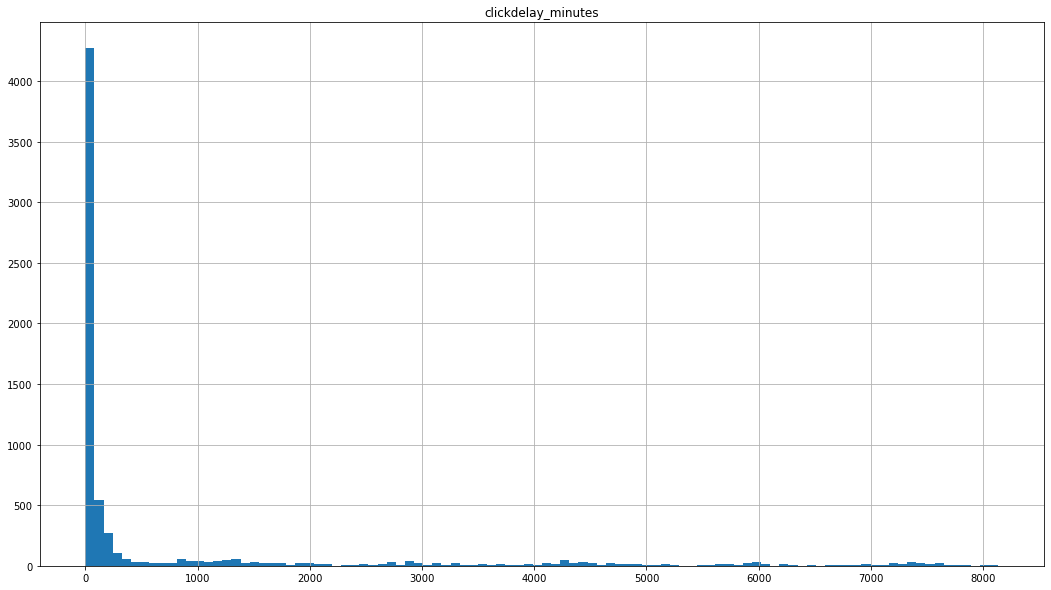

In [317]:
# 0, 1, 3
nblock = nbs[3]
print(asndb.get_asn_details(nblock_to_ip(nblock))[1:])
ua_analyzer(bdf, 'netblock', nblock)

In [318]:
show_delay_pctiles(bdf)

Percentiles for clickdelay_minutes:
5.0	0:00:58
25.0	0:30:35
50.0	4:08:03
75.0	6 days, 22:38:32
95.0	23 days, 9:17:24


In [319]:
uas = bdf.request_header_user_agent.value_counts().head(20).index.tolist()
bdf.request_header_user_agent.value_counts().head(10)

Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0)                                                                                                                                   48167
Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729)                                                         47208
Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Mobile/15E148 Safari/604.1                                                         44731
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36                                                                         17811
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36                                                                                10602


count: 17811
request_header_user_agent:
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36    17811
Name: request_header_user_agent, dtype: int64

request_header_user_agent__browser__family:
Chrome    17811
Name: request_header_user_agent__browser__family, dtype: int64

request_header_user_agent__browser__version_string:
53.0.2785    17811
Name: request_header_user_agent__browser__version_string, dtype: int64

request_header_user_agent__os__family:
Mac OS X    17811
Name: request_header_user_agent__os__family, dtype: int64

request_header_user_agent__os__version_string:
10.11.6    17811
Name: request_header_user_agent__os__version_string, dtype: int64

request_header_user_agent__is_mobile:
False    17811
Name: request_header_user_agent__is_mobile, dtype: int64

IP/24s:
54.202.215.0    789
54.186.231.0    776
34.219.100.0    723
34.220.15.0     719
18.237.130.0    718
34.222.133.0    715
54.188.78.0     489
34.212.18

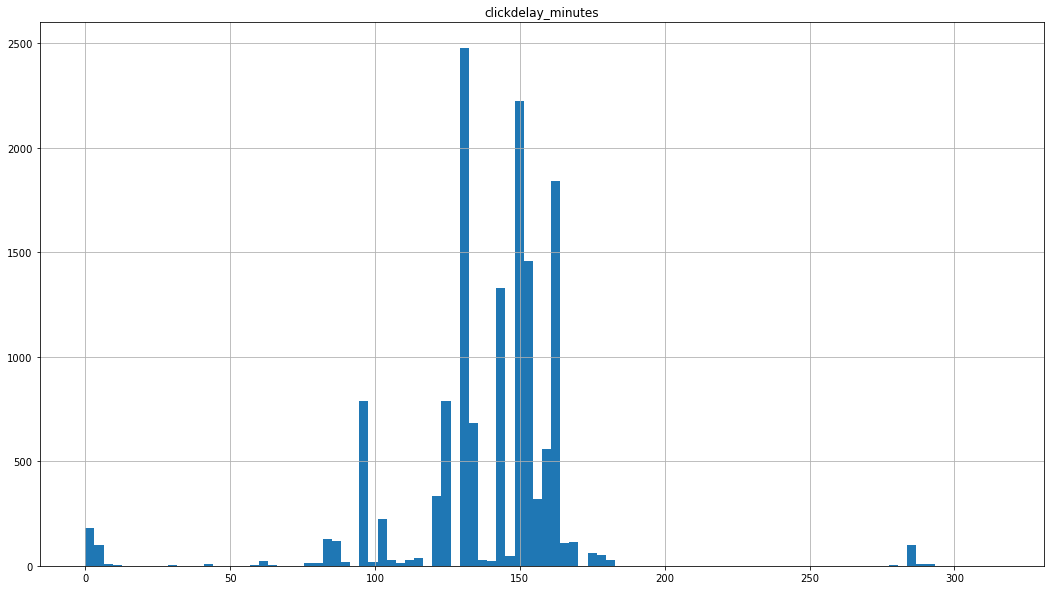

In [320]:
ua = uas[3]

ua_analyzer(bdf, 'request_header_user_agent', ua)

### I've already gone through the top 10 and identified some things that look more automated.
Let's quantify this using the same process as before.

In [321]:
b_suspicious_uas = ['Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0)',
    'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729)',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:67.0) Gecko/20100101 Firefox/67.0',
    'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; InfoPath.2)',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/78.0.3904.70 Safari/537.36']

b_suspicious_24s = ['209.222.82.0', '65.154.226.0', '45.41.142.0', '107.1.86.0', '198.209.37.0', '65.155.30.0']

In [322]:
bdf['suspicious_ua'] = bdf['request_header_user_agent'].isin(b_suspicious_uas)
bdf['suspicious_ua'].value_counts(normalize=True) * 100

False    62.017438
True     37.982562
Name: suspicious_ua, dtype: float64

In [323]:
bdf['suspicious_nb'] = bdf['ip_slash24'].isin(b_suspicious_24s)
bdf['suspicious_nb'].value_counts(normalize=True) * 100

False    80.961818
True     19.038182
Name: suspicious_nb, dtype: float64

In [324]:
bdf['both_suspicious'] = bdf[['suspicious_ua', 'suspicious_nb']].all(1)
bdf['both_suspicious'].value_counts(normalize=True) * 100

False    81.060901
True     18.939099
Name: both_suspicious, dtype: float64

In [325]:
bdf['either_suspicious'] = bdf[['suspicious_ua', 'suspicious_nb']].any(1)
bdf['either_suspicious'].value_counts(normalize=True) * 100

False    61.918354
True     38.081646
Name: either_suspicious, dtype: float64

## What's next?


In [327]:
import sklearn

# machine learning!